In [0]:
%tensorflow_version 1.15
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 800
batch_size = 128

seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

def load_data(file):
  with open(file, 'rb') as fo:
      try:
          samples = pickle.load(fo)
      except UnicodeDecodeError:  # python 3.x
          fo.seek(0)
          samples = pickle.load(fo, encoding='latin1')

  data, labels = samples['data'], samples['labels']

  data = np.array(data, dtype=np.float32)
  labels = np.array(labels, dtype=np.int32)

  labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
  labels_[np.arange(labels.shape[0]), labels - 1] = 1

  return data, labels_

def cnn(images, no_map1, no_map2):
  images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

  # Conv 1
  W_conv1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, no_map1], stddev=1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)),
                   name='weights_1')
  b_conv1 = tf.Variable(tf.zeros([no_map1]), name='biases_1')

  h_conv_1 = tf.nn.relu(tf.nn.conv2d(images, W_conv1, [1, 1, 1, 1], padding='VALID') + b_conv1)
  h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_1')

  # Conv 2
  W_conv2 = tf.Variable(tf.truncated_normal([5, 5, no_map1, no_map2], stddev=1.0 / np.sqrt(no_map1 * 5 * 5)),
                   name='weights_2')
  b_conv2 = tf.Variable(tf.zeros([no_map2]), name='biases_2')

  h_conv_2 = tf.nn.relu(tf.nn.conv2d(h_pool_1, W_conv2, [1, 1, 1, 1], padding='VALID') + b_conv2)
  h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_2')

  
  dim = h_pool_2.get_shape()[1].value * h_pool_2.get_shape()[2].value * h_pool_2.get_shape()[3].value
  # FC 1
  W_fc_1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0 / np.sqrt(dim)),
                   name='weights_3')
  b_fc_1 = tf.Variable(tf.zeros([300]), name='biases_3')
  
  pool_2_flat = tf.reshape(h_pool_2, [-1, dim])
  h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc_1) + b_fc_1)
  
  # Softmax
  W_fc_2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0 / np.sqrt(300)), name='weights_4')
  b_fc_2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
  logits = tf.matmul(h_fc1, W_fc_2) + b_fc_2

  keep_prob = 1

  return W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob

def cnn_dropout(images, no_map1, no_map2):
  images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])

  # Conv 1
  W_conv1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, no_map1], stddev=1.0 / np.sqrt(NUM_CHANNELS * 9 * 9)),
                   name='weights_1')
  b_conv1 = tf.Variable(tf.zeros([no_map1]), name='biases_1')

  h_conv_1 = tf.nn.relu(tf.nn.conv2d(images, W_conv1, [1, 1, 1, 1], padding='VALID') + b_conv1)
  h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_1')

  # Conv 2
  W_conv2 = tf.Variable(tf.truncated_normal([5, 5, no_map1, no_map2], stddev=1.0 / np.sqrt(no_map1 * 5 * 5)),
                   name='weights_2')
  b_conv2 = tf.Variable(tf.zeros([no_map2]), name='biases_2')

  h_conv_2 = tf.nn.relu(tf.nn.conv2d(h_pool_1, W_conv2, [1, 1, 1, 1], padding='VALID') + b_conv2)
  h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='pool_2')

  
  dim = h_pool_2.get_shape()[1].value * h_pool_2.get_shape()[2].value * h_pool_2.get_shape()[3].value
  # FC 1
  W_fc_1 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0 / np.sqrt(dim)),
                   name='weights_3')
  b_fc_1 = tf.Variable(tf.zeros([300]), name='biases_3')
  
  pool_2_flat = tf.reshape(h_pool_2, [-1, dim])
  h_fc1 = tf.nn.relu(tf.matmul(pool_2_flat, W_fc_1) + b_fc_1)
  
  keep_prob = tf.placeholder(tf.float32)
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  
  # Softmax
  W_fc_2 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0 / np.sqrt(300)), name='weights_4')
  b_fc_2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
  logits = tf.matmul(h_fc1_drop, W_fc_2) + b_fc_2

  return W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob

def train(no_map1, no_map2):  
  trainX, trainY = load_data('./data_batch_1')
  print(trainX.shape, trainY.shape)

  testX, testY = load_data('./test_batch_trim')
  print(testX.shape, testY.shape)

  trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  with tf.device('/device:GPU:0'):

    # Create the model
    x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn(x, no_map1, no_map2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      test_acc = []
      train_cost = []

      for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
          train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        

        if e%100 == 0:
          print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e,train_cost[e], test_acc[e]))
          
  return train_cost, test_acc

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [0]:
def train_with_momentum(no_map1, no_map2):  
  trainX, trainY = load_data('./data_batch_1')
  print(trainX.shape, trainY.shape)

  testX, testY = load_data('./test_batch_trim')
  print(testX.shape, testY.shape)

  trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  with tf.device('/device:GPU:0'):

    # Create the model
    x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn(x, no_map1, no_map2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.MomentumOptimizer(learning_rate, 0.1).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      test_acc = []
      train_cost = []

      for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
          train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        

        if e%100 == 0:
          print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e,train_cost[e], test_acc[e]))
          
  return train_cost, test_acc

In [0]:
def train_rms(no_map1, no_map2):  
  trainX, trainY = load_data('./data_batch_1')
  print(trainX.shape, trainY.shape)

  testX, testY = load_data('./test_batch_trim')
  print(testX.shape, testY.shape)

  trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  with tf.device('/device:GPU:0'):

    # Create the model
    x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn(x, no_map1, no_map2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      test_acc = []
      train_cost = []

      for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
          train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        

        if e%100 == 0:
          print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e,train_cost[e], test_acc[e]))
          
  return train_cost, test_acc

In [0]:
def train_adam(no_map1, no_map2):  
  trainX, trainY = load_data('./data_batch_1')
  print(trainX.shape, trainY.shape)

  testX, testY = load_data('./test_batch_trim')
  print(testX.shape, testY.shape)

  trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  with tf.device('/device:GPU:0'):

    # Create the model
    x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn(x, no_map1, no_map2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      test_acc = []
      train_cost = []

      for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
          train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})

        train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
        

        if e%100 == 0:
          print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e,train_cost[e], test_acc[e]))
          
  return train_cost, test_acc

In [0]:
def train_dropout(no_map1, no_map2):  
  trainX, trainY = load_data('./data_batch_1')
  print(trainX.shape, trainY.shape)

  testX, testY = load_data('./test_batch_trim')
  print(testX.shape, testY.shape)

  trainX = (trainX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  testX = (testX - np.min(trainX, axis=0)) / np.max(trainX, axis=0)
  with tf.device('/device:GPU:0'):

    # Create the model
    x = tf.placeholder(tf.float32, [None, IMG_SIZE * IMG_SIZE * NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    W_conv1, h_conv_1, h_pool_1, h_conv_2, h_pool_2, logits, keep_prob = cnn_dropout(x, no_map1, no_map2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
    correct_prediction = tf.cast(correct_prediction, tf.float32) # Cast to float
    accuracy = tf.reduce_mean(correct_prediction)

    N = len(trainX)
    idx = np.arange(N)

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      test_acc = []
      train_cost = []

      for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]

        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
          train_step.run(feed_dict={x: trainX[start:end], y_: trainY[start:end], keep_prob : 0.5})

        train_cost.append(loss.eval(feed_dict={x: trainX, y_: trainY, keep_prob : 0.5}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY, keep_prob : 0.5}))
        

        if e%100 == 0:
          print('Epoch {}: Train Cost = {}, Test Acc = {}'.format(e,train_cost[e], test_acc[e]))
          
  return train_cost, test_acc

========= GD =========
(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.2979607582092285, Test Acc = 0.125
Epoch 100: Train Cost = 1.7771862745285034, Test Acc = 0.3544999957084656
Epoch 200: Train Cost = 1.6129297018051147, Test Acc = 0.3840000033378601
Epoch 300: Train Cost = 1.4997283220291138, Test Acc = 0.35499998927116394
Epoch 400: Train Cost = 1.3965469598770142, Test Acc = 0.3370000123977661
Epoch 500: Train Cost = 1.259731411933899, Test Acc = 0.3894999921321869
Epoch 600: Train Cost = 1.1729365587234497, Test Acc = 0.3840000033378601
Epoch 700: Train Cost = 1.0824378728866577, Test Acc = 0.3714999854564667
========= Momentum =========
(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 2.2933764457702637, Test Acc = 0.14100000262260437
Epoch 100: Train Cost = 1.7773034572601318, Test Acc = 0.359499990940094
Epoch 200: Train Cost = 1.5918506383895874, Test Acc = 0.40149998664855957
Epoch 300: Train Cost = 1.462459683418274, Test Ac

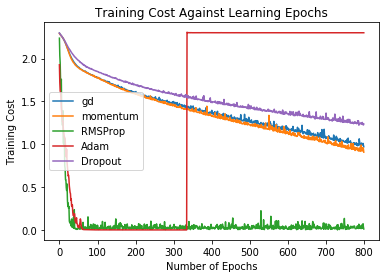

<Figure size 432x288 with 0 Axes>

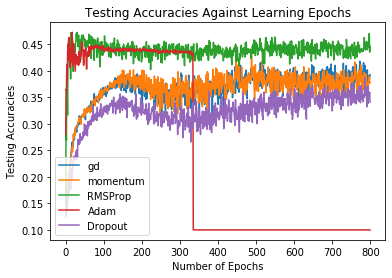

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

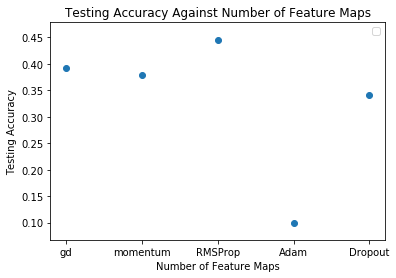

Adam
(10000, 3072) (10000, 10)
(2000, 3072) (2000, 10)
Epoch 0: Train Cost = 1.9818189144134521, Test Acc = 0.3034999966621399
Epoch 100: Train Cost = 0.5969293713569641, Test Acc = 0.44999998807907104
Epoch 200: Train Cost = 0.07305090129375458, Test Acc = 0.43700000643730164
Epoch 300: Train Cost = 0.004394836723804474, Test Acc = 0.453000009059906
Epoch 400: Train Cost = 0.0013267031172290444, Test Acc = 0.4584999978542328
Epoch 500: Train Cost = 0.0005054132197983563, Test Acc = 0.45899999141693115
Epoch 600: Train Cost = 0.00034296841477043927, Test Acc = 0.46700000762939453
Epoch 700: Train Cost = 6.202911026775837e-05, Test Acc = 0.4620000123977661


<Figure size 432x288 with 0 Axes>

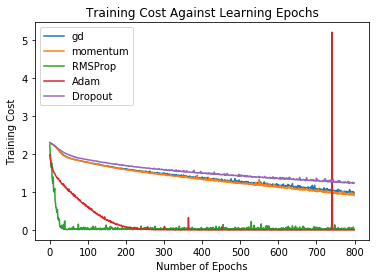

<Figure size 432x288 with 0 Axes>

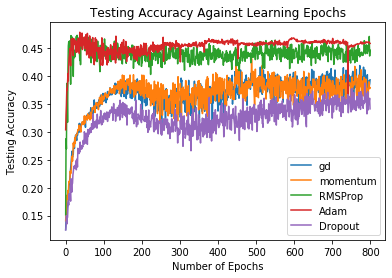

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

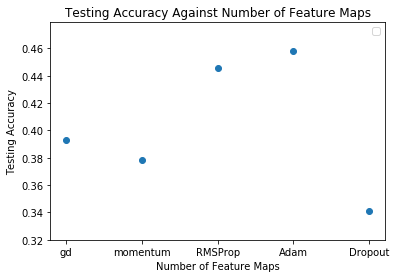

<Figure size 432x288 with 0 Axes>

In [0]:
print("========= GD =========")
train_cost, test_acc = train(80, 80)

print("========= Momentum =========")
train_cost_momentum, test_acc_momentum = train_with_momentum(80, 80)

print("========= RMS =========")
train_cost_rms, test_acc_rms = train_rms(80, 80)

print("========= Adam =========")
train_cost_adam, test_acc_adam = train_adam(80, 80)

print("========= Dropout =========")
train_cost_drop, test_acc_drop = train_dropout(80, 80)

plt.figure(1)
plt.plot(range(epochs), train_cost, label="gd")
plt.plot(range(epochs), train_cost_momentum, label="momentum")
plt.plot(range(epochs), train_cost_rms, label="RMSProp")
plt.plot(range(epochs), train_cost_adam, label="Adam")
plt.plot(range(epochs), train_cost_drop, label="Dropout")
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Training Cost')
plt.title("Training Cost Against Learning Epochs")
plt.show()
plt.savefig('./3_train_cost_1-1.png')

plt.figure(2)
plt.plot(range(epochs), test_acc, label="gd")
plt.plot(range(epochs), test_acc_momentum, label="momentum")
plt.plot(range(epochs), test_acc_rms, label="RMSProp")
plt.plot(range(epochs), test_acc_adam, label="Adam")
plt.plot(range(epochs), test_acc_drop, label="Dropout")
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Testing Accuracies')
plt.title("Testing Accuracies Against Learning Epochs")
plt.show()
plt.savefig('./3_test_acc_1-1.png')

plt.figure(3)

legend = ["gd", "momentum", "RMSProp", "Adam", "Dropout"]
test_acc_all = []
test_acc_all.append(test_acc)
test_acc_all.append(test_acc_momentum)
test_acc_all.append(test_acc_rms)
test_acc_all.append(test_acc_adam)
test_acc_all.append(test_acc_drop)

paras = [testing[-1] for testing in test_acc_all]

plt.scatter(range(len(test_acc_all)), paras)
plt.xticks(range(len(test_acc_all)), legend)

plt.xlabel('Number of Feature Maps')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Number of Feature Maps")
plt.show()
plt.savefig('./3_test_acc_1-2.png')

learning_rate = 1e-4
print("Adam")
train_cost_adam, test_acc_adam = train_adam(80, 80)

plt.figure(4)
plt.plot(range(epochs), train_cost, label="gd")
plt.plot(range(epochs), train_cost_momentum, label="momentum")
plt.plot(range(epochs), train_cost_rms, label="RMSProp")
plt.plot(range(epochs), train_cost_adam, label="Adam")
plt.plot(range(epochs), train_cost_drop, label="Dropout")
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Training Cost')
plt.title("Training Cost Against Learning Epochs")
plt.show()
plt.savefig('./3_train_cost_2-1.png')

plt.figure(5)
plt.plot(range(epochs), test_acc, label="gd")
plt.plot(range(epochs), test_acc_momentum, label="momentum")
plt.plot(range(epochs), test_acc_rms, label="RMSProp")
plt.plot(range(epochs), test_acc_adam, label="Adam")
plt.plot(range(epochs), test_acc_drop, label="Dropout")
plt.xlabel('Number of Epochs')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Learning Epochs")
plt.show()
plt.savefig('./3_test_acc_2-1.png')

plt.figure(6)

legend = ["gd", "momentum", "RMSProp", "Adam", "Dropout"]

test_acc_all = []
test_acc_all.append(test_acc)
test_acc_all.append(test_acc_momentum)
test_acc_all.append(test_acc_rms)
test_acc_all.append(test_acc_adam)
test_acc_all.append(test_acc_drop)

paras = [testing[-1] for testing in test_acc_all]

plt.scatter(range(len(test_acc_all)), paras)
plt.xticks(range(len(test_acc_all)), legend)

plt.xlabel('Number of Feature Maps')
plt.legend()
plt.ylabel('Testing Accuracy')
plt.title("Testing Accuracy Against Number of Feature Maps")
plt.show()
plt.savefig('./3_test_acc_2-2.png')